In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score, recall_score, precision_score, f1_score, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score, validation_curve, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from scipy import stats
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [ ]:
trans_data = pd.read_csv("card_transdata.csv")
trans_data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [ ]:
trans_data.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
trans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [ ]:
colors = ["#0E3547", "#92EAFF", "#6B6B6B"]

<Axes: >

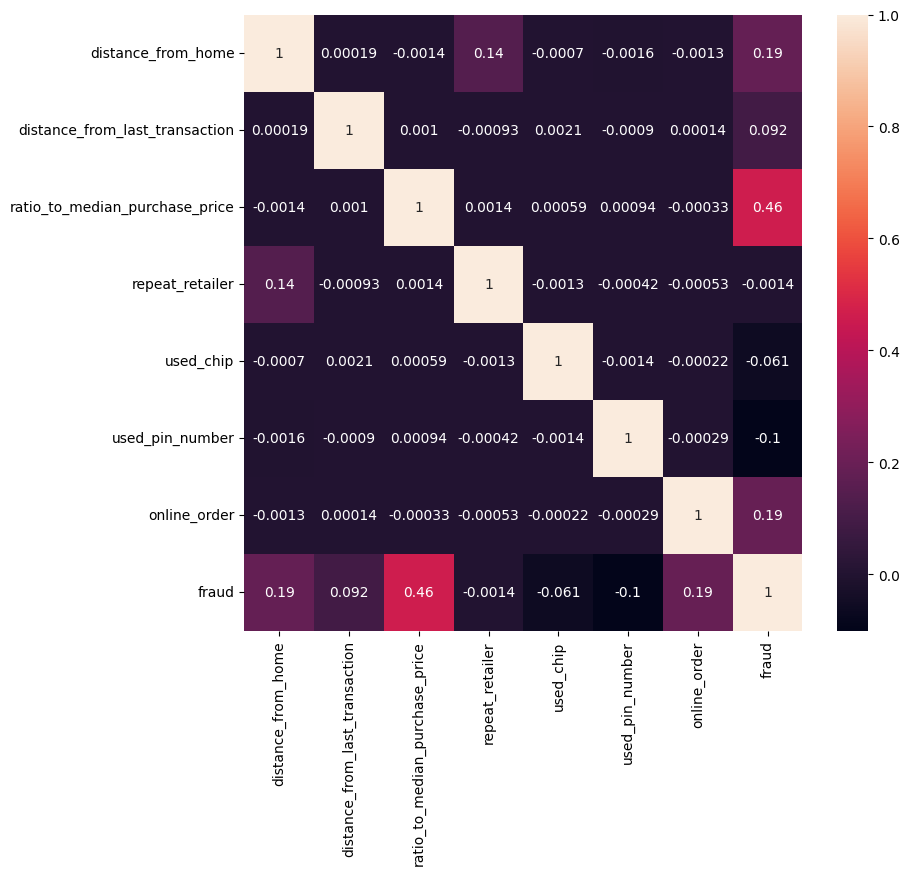

In [ ]:
fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(trans_data.corr(), annot=True)

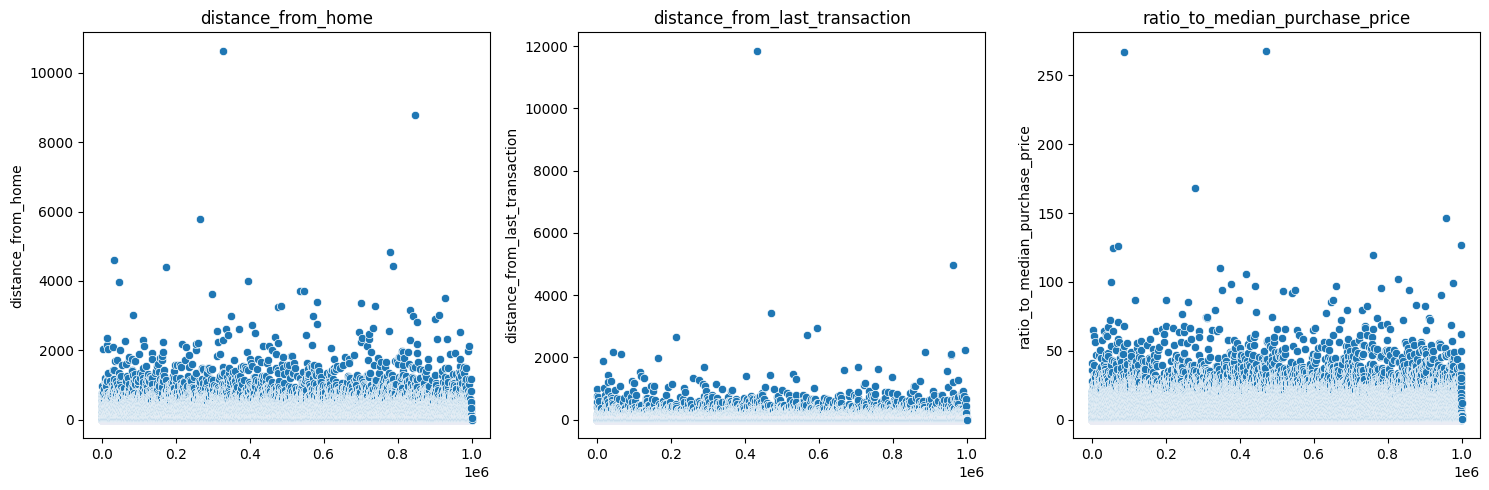

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.scatterplot(data=trans_data.distance_from_home)
plt.title('distance_from_home')

plt.subplot(132)
sns.scatterplot(data=trans_data.distance_from_last_transaction)
plt.title('distance_from_last_transaction')

plt.subplot(133)
sns.scatterplot(data=trans_data.ratio_to_median_purchase_price)
plt.title('ratio_to_median_purchase_price')

plt.tight_layout()

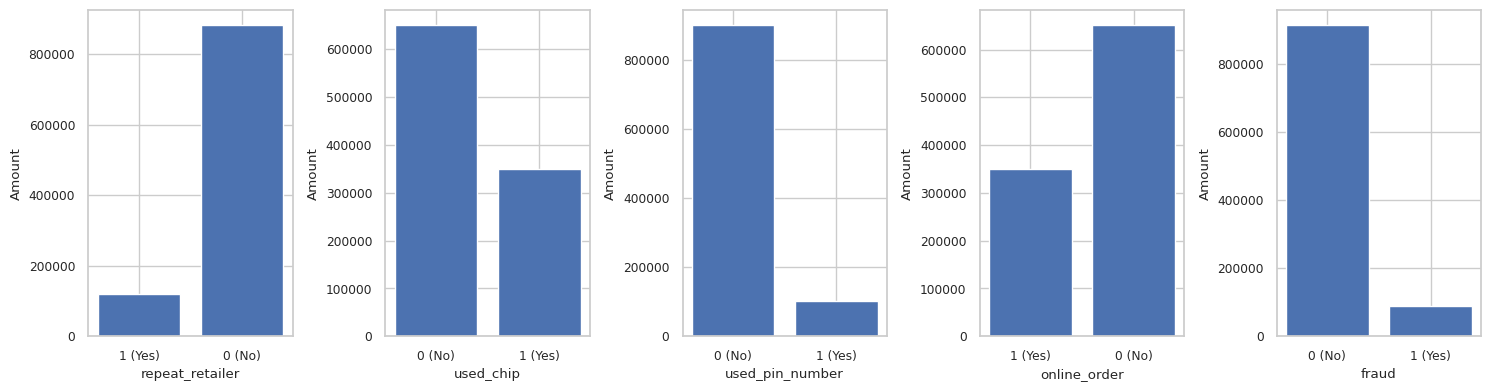

In [ ]:
columns_to_plot = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']

fig, axes = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(15, 4))

for i, column in enumerate(columns_to_plot):
    value_counts = trans_data[column].value_counts()
    axes[i].bar(value_counts.index, value_counts.values)
    axes[i].set_xticks(value_counts.index)
    axes[i].set_xticklabels(['0 (No)', '1 (Yes)'])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Amount')

plt.tight_layout()
plt.show()

Visualize the greatest concentration of data in the variables with the greatest number of outliers:

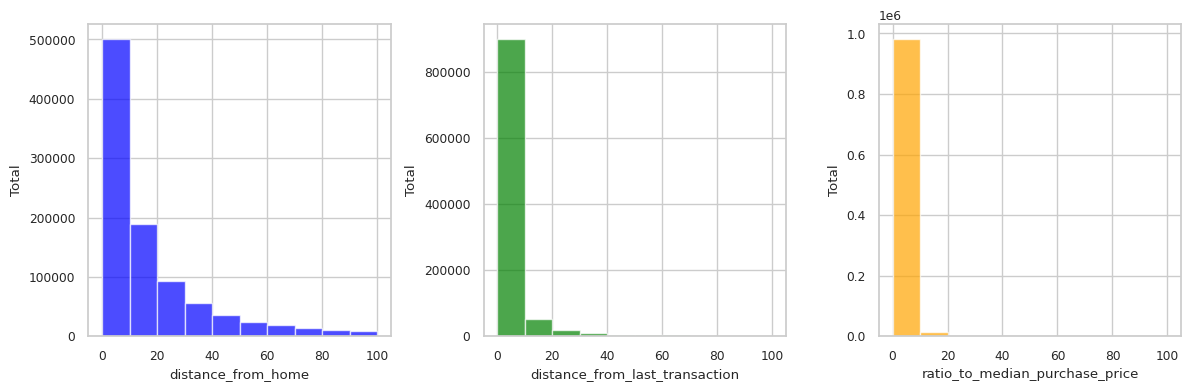

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

axes[0].hist(trans_data["distance_from_home"], bins=age_bins, color='blue', alpha=0.7)
axes[0].set_xlabel('distance_from_home')
axes[0].set_ylabel('Total')

axes[1].hist(trans_data["distance_from_last_transaction"], bins=age_bins, color='green', alpha=0.7)
axes[1].set_xlabel('distance_from_last_transaction')
axes[1].set_ylabel('Total')

axes[2].hist(trans_data["ratio_to_median_purchase_price"], bins=age_bins, color='orange', alpha=0.7)
axes[2].set_xlabel('ratio_to_median_purchase_price')
axes[2].set_ylabel('Total')

plt.tight_layout()
plt.show()

In [ ]:
def value_iqr(df, variable):
      q1 = round(df[variable].quantile(q = 0.25),2)
      q3 = round(df[variable].quantile(q = 0.75), 2)
      IQR = q3 - q1

      upper_limit = round(q3 + 3 * IQR , 2)
      return upper_limit

upper_limit_distance_from_home = value_iqr(trans_data, "distance_from_home")
upper_limit_distance_from_last_transaction = value_iqr(trans_data, "distance_from_last_transaction")
upper_limit_ratio_to_median_purchase_price = value_iqr(trans_data, "ratio_to_median_purchase_price")


<ipython-input-17-77ced01a866d>:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(data=trans_data, x="distance_from_home", bins=1000, color=colors[0], hue="fraud", ax=ax[0], element="step", palette=colors)
<ipython-input-17-77ced01a866d>:12: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(data=trans_data, x="distance_from_last_transaction", bins=1000, color=colors[0], hue="fraud", ax=ax[1], element="step", palette=colors)
<ipython-input-17-77ced01a866d>:20: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(data=trans_data, x="ratio_to_median_purchase_price", bins=2000, color=colors[0], hue="fraud", ax=ax[2],  element="step", palette=colors)


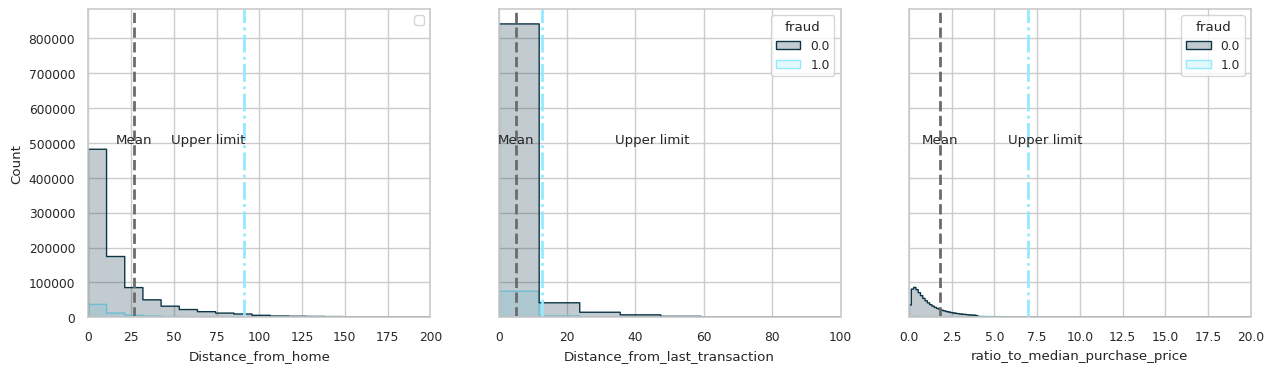

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,4), sharey=True)
sns.histplot(data=trans_data, x="distance_from_home", bins=1000, color=colors[0], hue="fraud", ax=ax[0], element="step", palette=colors)
ax[0].set_xlim(0, 200)
ax[0].axvline(np.mean(trans_data["distance_from_home"]), linewidth=2, color=colors[2], linestyle='--')
ax[0].axvline(upper_limit_distance_from_home, linewidth=2, color=colors[1], linestyle='-.')
ax[0].annotate("Mean", (np.mean(trans_data["distance_from_home"]),  500000), ha='center')
ax[0].annotate("Upper limit", (70,  500000), ha='center')
ax[0].set_xlabel("Distance_from_home")
ax[0].set_ylabel("Count")
ax[0].legend()

sns.histplot(data=trans_data, x="distance_from_last_transaction", bins=1000, color=colors[0], hue="fraud", ax=ax[1], element="step", palette=colors)
ax[1].set_xlabel("Distance_from_last_transaction")
ax[1].set_xlim(0, 100)
ax[1].axvline(np.mean(trans_data["distance_from_last_transaction"]), linewidth=2, color=colors[2], linestyle='--')
ax[1].annotate("Mean", (np.mean(trans_data["distance_from_last_transaction"]),  500000), ha='center')
ax[1].axvline(upper_limit_distance_from_last_transaction , linewidth=2, color=colors[1], linestyle='-.')
ax[1].annotate("Upper limit", (45,  500000), ha='center')

sns.histplot(data=trans_data, x="ratio_to_median_purchase_price", bins=2000, color=colors[0], hue="fraud", ax=ax[2],  element="step", palette=colors)
ax[2].set_xlabel("ratio_to_median_purchase_price")
ax[2].set_xlim(0, 20)
ax[2].axvline(np.mean(trans_data["ratio_to_median_purchase_price"]), linewidth=2, color=colors[2], linestyle='--')
ax[2].annotate("Mean", (np.mean(trans_data["ratio_to_median_purchase_price"]),  500000), ha='center')
ax[2].axvline( upper_limit_ratio_to_median_purchase_price , linewidth=2, color=colors[1], linestyle='-.')
ax[2].annotate("Upper limit", (8,  500000), ha='center')

plt.subplots_adjust(wspace=0.2)
plt.show()

In [ ]:
trans_data["fraud"].value_counts()

0.0    912597
1.0     87403
Name: fraud, dtype: int64

In [ ]:
trans_data[(trans_data["distance_from_home"] < upper_limit_distance_from_home) & (trans_data["distance_from_last_transaction"] < upper_limit_distance_from_last_transaction)
&(trans_data["ratio_to_median_purchase_price"] < upper_limit_ratio_to_median_purchase_price)]["fraud"].value_counts()

0.0    800526
1.0     34150
Name: fraud, dtype: int64

In [ ]:
trans_data_clean = trans_data[(trans_data["distance_from_home"] < upper_limit_distance_from_home) & (trans_data["distance_from_last_transaction"] < upper_limit_distance_from_last_transaction)
   & (trans_data["ratio_to_median_purchase_price"] < upper_limit_ratio_to_median_purchase_price)]
trans_data_clean.shape

(834676, 8)

___

In [ ]:
scaler = StandardScaler()
columns_scaled = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']

df_processing_scaler = scaler.fit_transform(trans_data_clean[columns_scaled])
df_processing_scaler = pd.DataFrame(df_processing_scaler, columns=columns_scaled)
df_processing_scaler = pd.concat([df_processing_scaler, trans_data_clean.drop(columns_scaled, axis=1)], axis=1)
df_processing_scaler.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,2.282309,-0.631022,0.386347,1.0,1.0,0.0,0.0,0.0
1,-0.290274,-0.684709,-0.093039,1.0,0.0,0.0,0.0,0.0
2,-0.604076,-0.435356,-0.730413,1.0,0.0,0.0,1.0,0.0
3,-0.759559,1.463774,-0.778263,1.0,1.0,0.0,1.0,0.0
4,1.533907,-0.529886,0.589973,1.0,1.0,0.0,1.0,0.0


In [ ]:
print("Number of registers:\n", trans_data_clean["fraud"].value_counts())

Number of registers:
 0.0    800526
1.0     34150
Name: fraud, dtype: int64


In [ ]:
X = trans_data_clean.drop(["fraud"], axis = 1)
y = trans_data_clean["fraud"]

undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_usmp, y_usmp = undersampler.fit_resample(X, y)
print("Number of registers:\n", y_usmp.value_counts())

Number of registers:
 0.0    34150
1.0    34150
Name: fraud, dtype: int64


In [ ]:
X_train, X_test_validation, y_train, y_test_validation = train_test_split(X_usmp, y_usmp, test_size=0.2, random_state=42)

X_test, X_validation, y_test, y_validation = train_test_split(X_test_validation, y_test_validation, test_size=0.5, random_state=42)
X_test.shape

(6830, 7)

In [ ]:
random_forest = RandomForestClassifier(n_estimators = 10, random_state = 42, max_depth = 2)
random_forest.fit(X_train, y_train)

In [ ]:
y_train_pred_f = random_forest.predict(X_train)
y_test_pred_f = random_forest.predict(X_test)
y_validation_pred_f = random_forest.predict(X_validation)

train_accuracy = accuracy_score(y_train, y_train_pred_f)
test_accuracy = accuracy_score(y_test, y_test_pred_f)
validation_accuracy = accuracy_score(y_validation, y_validation_pred_f)

print("Accuracy in Train:", train_accuracy)
print("Accuracy in Test:", test_accuracy)
print("Accuracy in Validation:", validation_accuracy)

y_pred = random_forest.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Accuracy in Train: 0.989586383601757
Accuracy in Test: 0.9897510980966325
Accuracy in Validation: 0.9887262079062957
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3361
           1       0.98      1.00      0.99      3469

    accuracy                           0.99      6830
   macro avg       0.99      0.99      0.99      6830
weighted avg       0.99      0.99      0.99      6830



In [ ]:
precision = cross_val_score(random_forest, X_usmp, y_usmp, cv=10, scoring="precision")
accuracy = cross_val_score(random_forest, X_usmp, y_usmp, cv=10, scoring="accuracy")

print("Mean precision:", precision.mean())
print("accuracy precision:", accuracy.mean())

Mean precision: 0.9837027584116098
accuracy precision: 0.9916983894582725


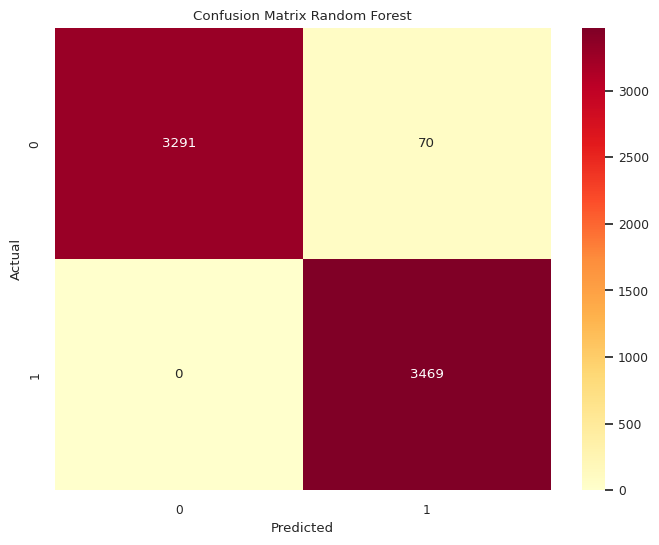

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_f)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Random Forest')
plt.show()

In [ ]:
parameter = {
    'n_estimators': [36],
    'max_depth': [9],
    'min_child_weight': [1],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
}

xgboost = xgb.XGBClassifier()
xgboost_search = RandomizedSearchCV(xgboost, param_distributions=parameter, cv=5, n_iter=10, n_jobs=-1)
xgboost_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8],
                                        'learning_rate': [0.1],
                                        'max_depth': [9],
                                        'min_child_weight': [1],
                                        'n_estimators': [36],
                                        'subsample': [0.8]})

In [ ]:
y_train_pred_xgb = xgboost_search.predict(X_train)
y_test_pred_xgb = xgboost_search.predict(X_test)
y_validation_pred_xgb = xgboost_search.predict(X_validation)

train_accuracy = accuracy_score(y_train, y_train_pred_xgb)
test_accuracy = accuracy_score(y_test, y_test_pred_xgb)
validation_accuracy = accuracy_score(y_validation, y_validation_pred_xgb)

print("Accuracy in Train:", train_accuracy)
print("Accuracy in Test:", test_accuracy)
print("Accuracy in Validation:", validation_accuracy)

y_pred = xgboost_search.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Accuracy in Train: 0.9997620790629576
Accuracy in Test: 0.9994143484626647
Accuracy in Validation: 0.9998535871156662
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3361
           1       1.00      1.00      1.00      3469

    accuracy                           1.00      6830
   macro avg       1.00      1.00      1.00      6830
weighted avg       1.00      1.00      1.00      6830



In [ ]:
precision = cross_val_score(xgboost_search, X_usmp, y_usmp, cv=10, scoring="precision")
accuracy = cross_val_score(xgboost_search, X_usmp, y_usmp, cv=10, scoring="accuracy")

print("Mean precision:", precision.mean())
print("accuracy precision:", accuracy.mean())

Mean precision: 0.9989749722829215
accuracy precision: 0.9988140556368961


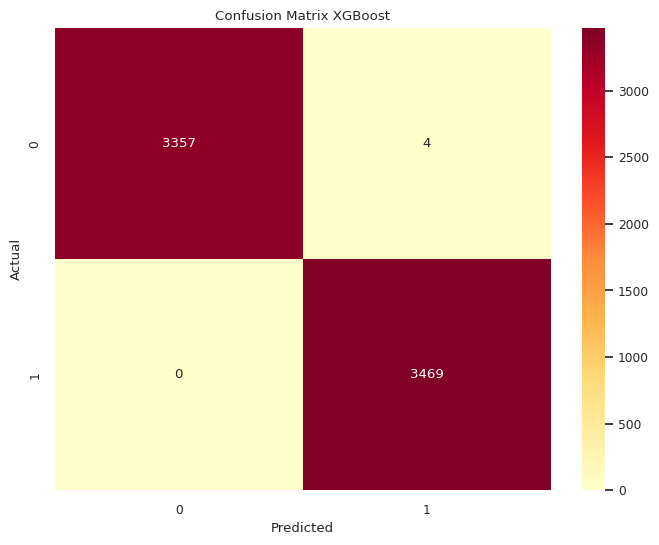

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix XGBoost')
plt.show()

In [ ]:
ensemble_model = VotingClassifier(estimators=[
    ('rf', random_forest),
    ('xgb', xgboost_search)
], voting='hard')

ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3361
           1       1.00      1.00      1.00      3469

    accuracy                           1.00      6830
   macro avg       1.00      1.00      1.00      6830
weighted avg       1.00      1.00      1.00      6830



In [ ]:
precision = cross_val_score(ensemble_model, X_usmp, y_usmp, cv=10, scoring="precision")
accuracy = cross_val_score(ensemble_model, X_usmp, y_usmp, cv=10, scoring="accuracy")

print("Mean precision:", precision.mean())
print("accuracy precision:", accuracy.mean())

Mean precision: 1.0
accuracy precision: 0.9993265007320644


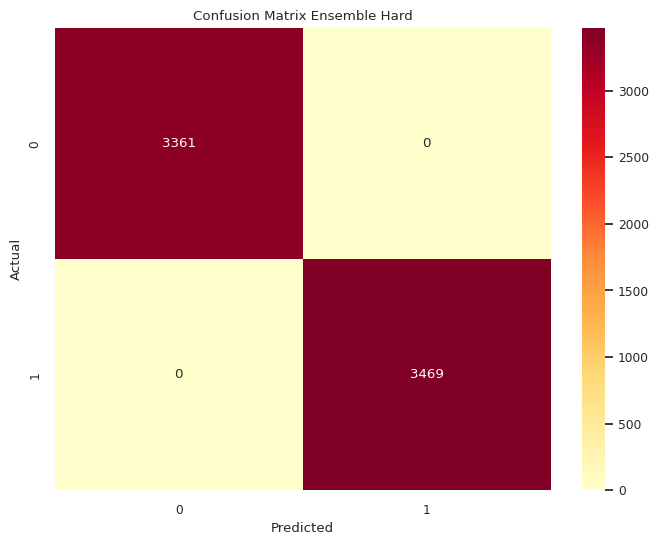

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Ensemble Hard')
plt.show()

In [ ]:
ensemble_model = VotingClassifier(estimators=[
    ('rf', random_forest),
    ('xgb', xgboost_search)
], voting='soft')

ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Accuracy: 0.9988286969253294
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3361
           1       1.00      1.00      1.00      3469

    accuracy                           1.00      6830
   macro avg       1.00      1.00      1.00      6830
weighted avg       1.00      1.00      1.00      6830



In [ ]:
precision = cross_val_score(ensemble_model, X_usmp, y_usmp, cv=10, scoring="precision")
accuracy = cross_val_score(ensemble_model, X_usmp, y_usmp, cv=10, scoring="accuracy")

print("Mean precision:", precision.mean())
print("accuracy precision:", accuracy.mean())

Mean precision: 0.9989471200487052
accuracy precision: 0.9993557833089313


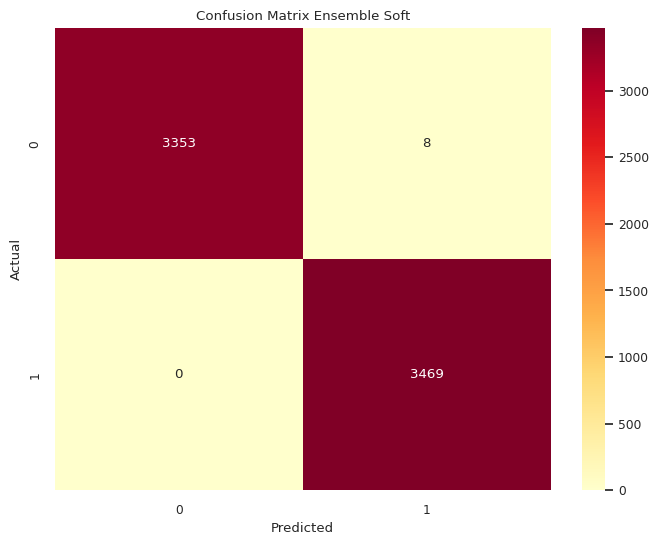

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Ensemble Soft')
plt.show()